In [340]:
from random import randint
import sys
import numpy as np
import collections
import networkx as nx
import os
import random
import time
import matplotlib.pyplot as plt

In [341]:
class greedy_algo:
    def __init__(self, degree_seq, k):
        self.degree_seq = degree_seq
        self.k = k
        
    def compute_I(self,seq):
        d_i = seq[0]
        res = 0
        for d_j in seq:
            res += d_i - d_j
        
        return res

    def c_merge(self, d1, ext):
        res = d1 - self.degree_seq[ext] +self.compute_I(self.degree_seq[ext+1: min(len(self.degree_seq), 2*ext)])
        return res

    def c_new(self,ext):
        t = self.degree_seq[ext:min(len(self.degree_seq), 2*ext-1)]
        res = self.compute_I(t)
        return res

    def greedy(self,initial_pos, extension):
        if initial_pos + extension >= len(self.degree_seq)-1:
            for i in range(initial_pos,len(self.degree_seq)):
                self.degree_seq[i] = self.degree_seq[initial_pos]
                return self.degree_seq
        else:
            d1 = self.degree_seq[initial_pos]
            cost_cmerge = self.c_merge(d1,initial_pos+extension)
            c_new_cost = self.c_new(initial_pos+extension)

            if cost_cmerge > c_new_cost:
                for i in range(initial_pos, initial_pos+extension):
                    self.degree_seq[i] = d1

                return self.greedy(initial_pos+extension, self.k)
            else:
                return self.greedy(initial_pos,extension+1)

In [342]:
class dynamic_algo:
    def __init__(self, k):
        self.k = k
        
    def calculate_anonymous_cost(self, old_degrees,new_degrees):
        cost = 0
        for i, j in zip(old_degrees,new_degrees):
            cost = abs(cost + (j-i))
        return cost
               
    def merge(self, list_a):
        anonymous_list = [max(list_a)]*len(list_a)
        cost = self.calculate_anonymous_cost(list_a,anonymous_list)
        return cost, anonymous_list    

    def dynamic(self, degree_seq,mem=None):

        if mem is None:
            mem = {}

        dict_cost_degs = {}
        cost = []
        degree_sec = []

        if self.k == 1:
            return 0, degree_seq
        elif self.k > len(degree_seq)/2:
            return self.merge(degree_seq)
        else:
            dict_cost_degs.clear()
            max_t= len(degree_seq) - self.k+1
            min_t= self.k

            for i in range(min_t,max_t):
                annoynm = degree_seq[0: i]
                similar_g = degree_seq[i: len(degree_seq)]
                nodes = len(degree_seq)
                if (i, len(degree_seq)) in mem.keys():
                    mem_data = mem.get((i, nodes))
                    i_cost, i_annoym_degs = mem_data[0], mem_data[1]
                else:
                    cost_anonym, degs_anonym = self.dynamic(annoynm,mem)
                    cost_sim_g, sim_g_degs = self.merge(similar_g)
                    i_cost = cost_anonym + cost_sim_g
                    i_annoym_degs = degs_anonym + sim_g_degs
                    mem[(i, len(degree_seq))] = (i_cost, i_annoym_degs)

                degree_sec.append(i_annoym_degs) 
                cost.append(i_cost)   
                dict_cost_degs[i_cost] = i_annoym_degs

            result = min(dict_cost_degs.items(), key = lambda x: x[0])
            return result

In [343]:
class dynamic_optimize(dynamic_algo):
    def __init__(self, k):
        super().__init__(k)
        
    def dynamicOptimised(self,array_deg,mem=None):

        if mem is None:
            mem = {}

        dict_cost_degs = {}
        cost = []
        degree_sec = []

        if self.k == 1:
            return 0, array_deg
        elif self.k > len(array_deg)/2:
            return self.merge(array_deg)
        else:
            dict_cost_degs.clear()
            max_t= len(array_deg) - self.k+1 
            min_t= max(self.k, (len(array_deg) - 2*self.k + 1)) #Optimised

            for i in range(min_t,max_t):
                annoynm = array_deg[0: i]
                similar_g = array_deg[i: len(array_deg)]
                nodes = len(array_deg)
                if (i, len(array_deg)) in mem.keys():
                    mem_data = mem.get((i, nodes))
                    i_cost, i_annoym_degs = mem_data[0], mem_data[1]
                else:
                    cost_anonym, degs_anonym = self.dynamicOptimised(annoynm,mem)
                    cost_sim_g, sim_g_degs = self.merge(similar_g)
                    i_cost = cost_anonym + cost_sim_g
                    i_annoym_degs = degs_anonym + sim_g_degs
                    mem[(i, len(array_deg))] = (i_cost, i_annoym_degs)

                degree_sec.append(i_annoym_degs) 
                cost.append(i_cost)   
                dict_cost_degs[i_cost] = i_annoym_degs  
            return min(dict_cost_degs.items(), key = lambda x: x[0])

In [344]:
# A function to reconstruct the graph
def construct_graph(tab_index, anonymized_degree):
    original_index = tab_index
    graph = nx.Graph()
    if sum(anonymized_degree) % 2 == 1:
        return None

    while True:
        if not all(di >= 0 for di in anonymized_degree):
            return None
        if all(di == 0 for di in anonymized_degree):
            return graph
        v = np.random.choice((np.where(np.array(anonymized_degree) > 0))[0])
        dv = anonymized_degree[v]
        anonymized_degree[v] = 0
        for index in np.argsort(anonymized_degree)[-dv:][::-1]:
            if index == v:
                return None
            if not graph.has_edge(tab_index[v], tab_index[index]):
                graph.add_edge(tab_index[v], tab_index[index])
                anonymized_degree[index] = anonymized_degree[index] - 1

In [360]:
# G= nx.Graph()
# with open('sample_data/graph_friend_100_10_100.csv') as f: 
#     line = f.readlines()
# lines = [i.strip() for i in line]
# for j in lines: 
#     names = j.split(",")
#     start_node = names[0]
#     if start_node not in G:
#         G.add_node(start_node)
#     for k in range(1,len(names)):
#         node_to_add = names[k]
#         if node_to_add not in G:
#             G.add_node(node_to_add)
#         G.add_edge(start_node,node_to_add)

In [373]:
G = nx.read_gml('sample_data/lesmis.gml')
#G1 = nx.barabasi_albert_graph(770,12)
array_deg = np.array(list(map(lambda x:x[1], G.degree())))
G.number_of_nodes()

77

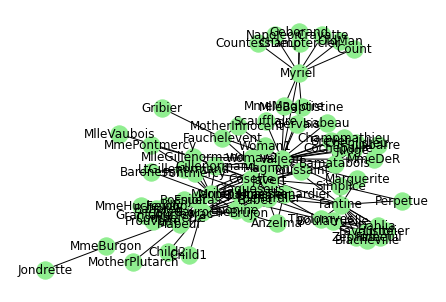

In [374]:
#Original graph
nx.draw(G, with_labels = True,node_color="lightgreen") 

In [386]:
degrees_arr = [degrees[1] for degrees in G.degree()]
array_index = np.argsort(degrees_arr)[::-1]
array_deg = np.sort(degrees_arr)[::-1]

[36 36 36 36 36 36 36 13 13 13 13 13 13 13 11 11 11 11 11 11 11 11  9  9
  9  9  9  9  9  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  3  3  3  3
  3  3  3  2  2  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1]


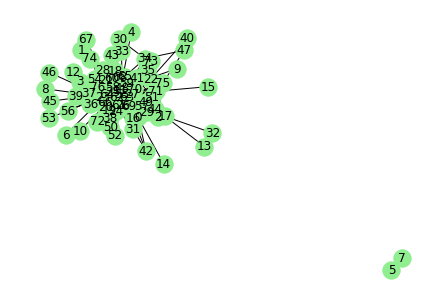

In [377]:
#Annoymised graph
print(array_deg)
greedy_obj = greedy_algo(array_deg,5);
results_greedy = greedy_obj.greedy(0,5);
gra_ph = construct_graph(array_index, results_greedy)
nx.draw(gra_ph, with_labels = True,node_color="lightgreen") 

In [397]:
graph_arr = []
cc_greedy = []
cc_dynamic = []
cc_dpo = []
apl_dpo = []
apl_greedy = []
apl_dynamic = []
apl_dpo = []
k_greedy = []
k_dynamic = []
k_dpo = []
time_greedy = []
time_dynamic = []
time_dpo = []
arr_R = []
arr_R_dpo = []
k_arr = list(range(5,21))

for i in k_arr:
    graph_arr = []
    original_deg = np.sort(array_deg)[::-1] 
    greedy_obj = greedy_algo(np.sort(array_deg)[::-1],i);
    dynamic_algo_obj = dynamic_algo(i);
    dynamic_algo_opt_obj = dynamic_optimize(i);
    
    start_time = time.time()
    results_greedy = greedy_obj.greedy(0,i);
    end_time = time.time()
    time_greedy.append(end_time-start_time)
    
    start_time = time.time()
    result_dynamic  = dynamic_algo_obj.dynamic(np.sort(array_deg)[::-1] , None);
    end_time = time.time()
    time_dynamic.append(end_time - start_time)
    
    start_time = time.time()
    result_dynamic_opt = dynamic_algo_opt_obj.dynamicOptimised(np.sort(array_deg)[::-1] , None);
    end_time = time.time()
    time_dpo.append(end_time-start_time)

    greedy_anonymised_graph = construct_graph(np.argsort(array_deg)[::-1], results_greedy)
    dynamic_anonymised_graph = construct_graph(np.argsort(array_deg)[::-1], result_dynamic[1])
    dynamic_opt_anonymised_graph = construct_graph(np.argsort(array_deg)[::-1], result_dynamic_opt[1])

    if results_greedy is not None:
        greedy_cost = dynamic_algo_obj.calculate_anonymous_cost(original_deg,results_greedy)
    else:
        greedy_cost = 1
           
    try:
        arr_R_dpo.append(greedy_cost/result_dynamic_opt[0])
    except:
        pass
    graph_arr.append(("greedy",greedy_anonymised_graph))
    graph_arr.append(("dynamic",dynamic_anonymised_graph))
    graph_arr.append(("dynamic_opt",dynamic_opt_anonymised_graph))
    
    for graph in graph_arr:
        if graph[1] is not None and nx.is_connected(graph[1]):
          if(graph[0] == "greedy"):
                k_greedy.append(i)
                cc_greedy.append(nx.average_clustering(graph[1]))
                apl_greedy.append(nx.average_shortest_path_length(graph[1]))
          elif (graph[0] == "dynamic"):
                k_dynamic.append(i)
                cc_dynamic.append(nx.average_clustering(graph[1]))
                apl_dynamic.append(nx.average_shortest_path_length(graph[1]))
          else:
                k_dpo.append(i)
                cc_dpo.append(nx.average_clustering(graph[1]))
                apl_dpo.append(nx.average_shortest_path_length(graph[1]))
        else:
            pass


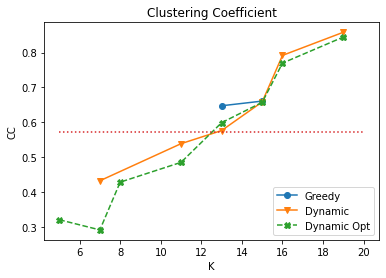

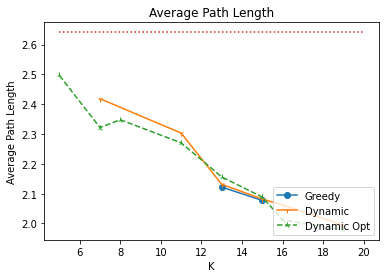

In [398]:
plt.plot(k_greedy, cc_greedy, marker='o')
plt.plot(k_dynamic, cc_dynamic,marker = 'v')
plt.plot(k_dpo, cc_dpo,marker = 'X',linestyle='dashed')
plt.plot(k_arr, [nx.average_clustering(G)]*len(k_arr),linestyle='dotted')
plt.legend(["Greedy","Dynamic", "Dynamic Opt"], loc ="lower right")
plt.title('Clustering Coefficient')
plt.xlabel('K')
plt.ylabel('CC')
plt.show()

plt.plot(k_greedy, apl_greedy, marker='o')
plt.plot(k_dynamic, apl_dynamic, marker = '1')
plt.plot(k_dpo, apl_dpo,marker = '2', linestyle='dashed')
plt.plot(k_arr, [nx.average_shortest_path_length(G)]*len(k_arr),linestyle='dotted')

plt.legend(["Greedy","Dynamic", "Dynamic Opt"], loc ="lower right")
plt.title('Average Path Length')
plt.xlabel('K')
plt.ylabel('Average Path Length')
plt.show()

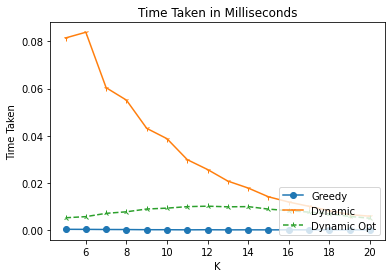

In [399]:
plt.plot(k_arr, time_greedy, marker='o')
plt.plot(k_arr, time_dynamic, marker = '1')
plt.plot(k_arr, time_dpo ,marker = '2', linestyle='dashed')
plt.legend(["Greedy","Dynamic", "Dynamic Opt"], loc ="lower right")
plt.title('Time Taken in Milliseconds')
plt.xlabel('K')
plt.ylabel('Time Taken')
plt.show()

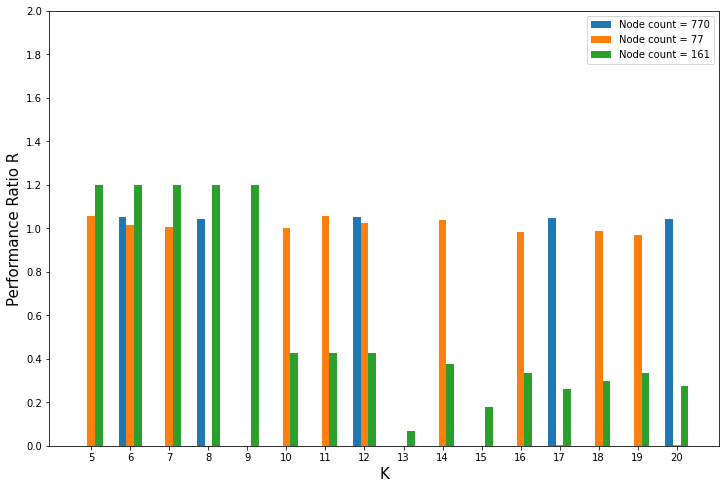

In [ ]:
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
AB = [0.0, 1.0542168674698795, 0.0, 1.0453296703296704, 0.0, 0.0, 0.0, 1.0515548281505729, 0.0, 0.0, 0.0, 0.0, 1.0470521541950113, 0.0, 0.0, 1.041705716963449]
LM = [1.058139534883721, 1.017094017094017, 1.0072463768115942, 0.0, 0.0, 1.0, 1.0546218487394958, 1.0224719101123596, 0.0, 1.036697247706422, 0.0, 0.9834905660377359, 0.002288329519450801, 0.989451476793249, 0.9673076923076923, 0.003629764065335753]
FG = [1.2,1.2,1.2,1.2,1.2,0.42857142857142855,0.42857142857142855,0.42857142857142855,0.06666666666666667,0.375,0.17647058823529413,0.3333333333333333,0.2631578947368421,0.3,0.3333333333333333,0.2727272727272727]
 
br1 = np.arange(len(AB))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
plt.bar(br1, AB, width = barWidth,
         label ='Node count = 770')
plt.bar(br2, LM,  width = barWidth,
         label ='Node count = 77')
plt.bar(br3, FG,  width = barWidth,
         label ='Node count = 161')
 
# Adding Xticks
plt.xlabel('K',  fontsize = 15)
plt.ylabel('Performance Ratio R', fontsize = 15)
plt.yticks([0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2])
plt.xticks([r + barWidth for r in range(len(AB))],
        k_arr)
plt.legend()
plt.show()